In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import datetime
import os
import gc

In [28]:
df_train = pd.read_csv('data/train.csv')

In [29]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [30]:
targets= df_train.target

In [31]:
filenames = ['data/jpeg/train/' + fname + '.jpg' for fname in df_train.image_name]

In [32]:
X = filenames
y = pd.get_dummies(targets)

In [33]:
# Set number of images to use for experimenting
First_Image = 15000
Last_Image = 30000

In [34]:
x_train, x_val, y_train, y_val = train_test_split(X[:], y[:], test_size = 0.2, random_state = 42)

In [35]:
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [36]:
def create_df(image, target):
    image = process_image(image)
    return image, target

In [37]:
BATCH_SIZE = 10

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train), tf.constant(y_train)))
train_data = train_data.map(create_df).batch(BATCH_SIZE).shuffle(buffer_size=len(x_train))

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_val), tf.constant(y_val)))
val_data = val_data.map(create_df).batch(BATCH_SIZE)

In [38]:
train_data

<ShuffleDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.uint8)>

In [39]:
INPUT_SIZE = [None, IMG_SIZE,IMG_SIZE, 3]
HIDDEN_SIZE1 = 256
HIDDEN_SIZE2 = 128
HIDDEN_SIZE3 = 64
OUTPUT_SIZE = 2

In [40]:
Total_num_img = len(df_train)
Num_mlg = np.count_nonzero(df_train.target)
Num_bng = Total_num_img - Num_mlg

In [41]:
Weight_bng = 1/Num_bng * Total_num_img/2
Weight_mlg = 1/Num_mlg * Total_num_img/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

In [42]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [43]:
def create_model(retrain = False):
    model = []
    if retrain:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key=os.path.getctime)
        model = load_model(model_path)
        model.summary()
    else:
        model = Sequential([
                    Conv2D(64, kernel_size = 5, padding = 'VALID', activation = 'relu'),
                    MaxPooling2D(pool_size = 5),

                    Flatten(),
                    Dense(HIDDEN_SIZE1,activation='relu'),
                    Dropout(0.2),
                    
                    Dense(HIDDEN_SIZE2,activation='relu'),
                    Dropout(0.2),
                    
                    Dense(HIDDEN_SIZE3,activation='relu'),

                    Dense(OUTPUT_SIZE, activation='softmax')])

        model.build(INPUT_SIZE)

        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-5),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = ['accuracy'])

        model.summary()
    return model

In [44]:
model = create_model(False)

NameError: name 'HIDDEN_SIZE1' is not defined

In [45]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4)

In [46]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
gc.collect()

8266

In [21]:
history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=EarlyStopping, class_weight = class_weights)

Epoch 1/100
1200/1200 [==============================] - 847s 706ms/step - loss: 0.6737 - accuracy: 0.1272 - val_loss: 0.7171 - val_accuracy: 0.0217
Epoch 2/100
1200/1200 [==============================] - 835s 696ms/step - loss: 0.6694 - accuracy: 0.3749 - val_loss: 0.6898 - val_accuracy: 0.7557
Epoch 3/100
1200/1200 [==============================] - 838s 698ms/step - loss: 0.6668 - accuracy: 0.5955 - val_loss: 0.6707 - val_accuracy: 0.9767
Epoch 4/100
1200/1200 [==============================] - 845s 705ms/step - loss: 0.6668 - accuracy: 0.8002 - val_loss: 0.6571 - val_accuracy: 0.9780
Epoch 5/100
1200/1200 [==============================] - 840s 700ms/step - loss: 0.6658 - accuracy: 0.8805 - val_loss: 0.6460 - val_accuracy: 0.9783
Epoch 6/100
1200/1200 [==============================] - 845s 704ms/step - loss: 0.6651 - accuracy: 0.9247 - val_loss: 0.6381 - val_accuracy: 0.9783
Epoch 7/100
1200/1200 [==============================] - 835s 696ms/step - loss: 0.6661 - accuracy: 0.9407

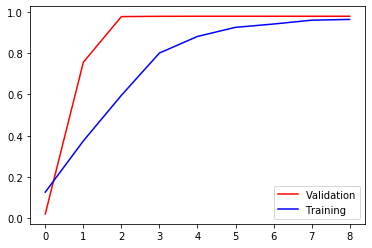

In [22]:
plt.plot(history.history['val_accuracy'], color = 'red')
plt.plot(history.history['accuracy'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.show()

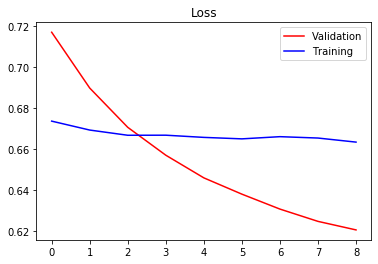

In [23]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

In [24]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [25]:
save_model(model, suffix=str(['Images', First_Image, '_', Last_Image]))

Saving model to: models\20200701000406-['Images', 0, '_', 15000].h5...


"models\\20200701000406-['Images', 0, '_', 15000].h5"

In [26]:
sfx = "Images {}_{}".format(First_Image, Last_Image)
save_model(model, suffix=sfx)

Saving model to: models\20200701000406-Images 0_15000.h5...


'models\\20200701000406-Images 0_15000.h5'